<a href="https://colab.research.google.com/github/aserravalle/LightGBM-Predict-Valuable-Customers/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pip install kmeans_smote 

In [0]:
# Data Frame Manipulation
import numpy as np
import pandas as pd

# Date
import time
import datetime

# Feature Engineering and Preprocessing
from kmeans_smote import KMeansSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Plotting tools
import matplotlib.pyplot as plt

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

# MACHINE LEARNING BABY
import tensorflow as tf

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [0]:
# load training dataset
df = pd.read_csv("Marketing_Train.csv")
df.head()

,id,age,job,marital,education,default,housing,loan,contact,year,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1,56,housemaid,married,basic.4y,no,no,no,telephone,2008,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2,57,services,married,high.school,unknown,no,no,telephone,2008,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,3,37,services,married,high.school,no,yes,no,telephone,2008,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,4,40,admin.,married,basic.6y,no,no,no,telephone,2008,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,5,56,services,married,high.school,no,no,yes,telephone,2008,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
# load testing dataset
df_eval = pd.read_csv("Marketing_Eval.csv")

df_eval.head()

,id,age,job,marital,education,default,housing,loan,contact,year,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,39781,50,management,married,university.degree,no,no,no,telephone,2010,jun,mon,5,6,1,success,-1.7,94.055,-39.8,0.720,4991.6
1,39782,21,student,single,high.school,no,yes,no,cellular,2010,jun,mon,1,999,0,nonexistent,-1.7,94.055,-39.8,0.720,4991.6
2,39783,34,admin.,single,university.degree,no,yes,no,telephone,2010,jun,mon,1,999,0,nonexistent,-1.7,94.055,-39.8,0.733,4991.6
3,39784,38,technician,single,university.degree,no,yes,no,cellular,2010,jun,mon,6,999,0,nonexistent,-1.7,94.055,-39.8,0.754,4991.6
4,39785,32,technician,married,university.degree,no,no,no,cellular,2010,jun,mon,3,999,1,failure,-1.7,94.055,-39.8,0.754,4991.6


# Data Cleaning

In [0]:
def Clean(df):
  # Dropping unknown
  df.replace('unknown', np.nan, inplace = True)

  # Encoding - Binary
  if 'y' in df.columns:
    df.y.replace(('yes','no'),(1,0), inplace=True)
  df.contact.replace(('cellular','telephone'),(0,1), inplace=True)
  df.default.replace(('no','yes'),(0,1), inplace=True)
  df.housing.replace(('no','yes'),(0,1), inplace=True)
  df.loan.replace(('no','yes'),(0,1), inplace=True)

  # Contact is now an indicator variable if = Telephone. Rename to avoid confusion
  df.rename(columns = {'contact':'contact_tel'}, inplace = True)
  
  # Indicate 'unknown' data
  MissingIndex = pd.Series(np.where(df.isnull())[0]).unique()
  df['Missing'] = 0
  df.loc[a,'Missing'] = 1

  # Right censoring pdays = 999
  df['called'] = np.where(df['pdays'] == 999, 1, 0)
  Max = max(df['pdays'][df['pdays'] != 999])
  df['pdays'][df['pdays'] == 999] = Max

  # Combine year and month using date time, drop those variables
  df['date'] = df['month'] + df['year'].astype(str)
  dateparse = lambda x: pd.datetime.strptime(x, '%b%Y')
  df['date'] = df['date'].apply(dateparse)
  df.drop(['year','month'], axis = 1, inplace = True)

  # Encoding - Categorical
  Encode = ['job','marital','education','day_of_week','poutcome']
  df = pd.get_dummies(df,columns = Encode)

  return df

In [0]:
df2 = Clean(df)
df_eval2 = Clean(df_eval)

df2.to_csv('train_missing.csv',  index = False)
df_eval2.to_csv('eval_missing.csv',  index = False)

print('Training and Testing Data have been cleaned and saved')

Training and Testing Data have been cleaned and saved


# KNN Imputation of Missing Values

R can do this more easily so we will save the file and do it there

In [0]:
## R Code Looks like this:

'''
install.packages('VIM)
library(VIM)
df = read.csv('train_missing.csv', stringsAsFactors = FALSE)
df2 = kNN(df)
write.csv(df2,"train_nomissing.csv",row.names=F)
'''

# Exploratory Data Analysis

## Training

In [0]:
# Read the new file
df = pd.read_csv("train_nomissing.csv")
df.head()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,called,date,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
0,56,0,0,0,1,1,21,0,1.1,93.994,-36.4,4.857,5191.0,0,1,2008-05-01,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,57,0,0,0,1,1,21,0,1.1,93.994,-36.4,4.857,5191.0,0,1,2008-05-01,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2,37,0,1,0,1,1,21,0,1.1,93.994,-36.4,4.857,5191.0,0,1,2008-05-01,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,40,0,0,0,1,1,21,0,1.1,93.994,-36.4,4.857,5191.0,0,1,2008-05-01,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,56,0,0,1,1,1,21,0,1.1,93.994,-36.4,4.857,5191.0,0,1,2008-05-01,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [0]:
df.describe()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,called,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
count,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000,39780.000000
mean,39.987758,0.000075,0.537406,0.152916,0.371041,2.591629,20.608572,0.139593,0.135377,93.551424,-40.464726,3.718171,5173.692366,0.098944,0.974661,0.251106,0.230342,0.036073,0.025792,0.071368,0.038738,0.034816,0.097587,0.018351,0.163851,0.024007,0.112167,0.610030,0.275817,0.101609,0.056938,0.149950,0.230995,0.000452,0.126621,0.292232,0.190850,0.206285,0.209100,0.196280,0.197486,0.097260,0.879462,0.023278,0.265058
std,10.174605,0.008684,0.498605,0.359911,0.483089,2.803686,2.485788,0.409110,1.571117,0.572449,4.617397,1.685206,64.046924,0.298591,0.157156,0.433655,0.421057,0.186475,0.158516,0.257441,0.192972,0.183317,0.296759,0.134219,0.370145,0.153073,0.315576,0.487749,0.446931,0.302137,0.231727,0.357027,0.421475,0.021267,0.332553,0.454794,0.392976,0.404642,0.406671,0.397187,0.398107,0.296315,0.325594,0.150787,0.441370
min,17.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.000000,0.634000,5008.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,38.000000,0.000000,1.000000,0.000000,0.000000,2.000000,21.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5195.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,47.000000,0.000000,1.000000,0.000000,1.000000,3.000000,21.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,98.000000,1.000000,1.000000,1.000000,1.000000,56.000000,21.000000,5.000000,1.400000,94.465000,-26.900000,5.045000,5228.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [0]:
df.shape

(39780, 46)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39780 entries, 0 to 39779
Data columns (total 46 columns):
age                              39780 non-null int64
default                          39780 non-null int64
housing                          39780 non-null int64
loan                             39780 non-null int64
contact_tel                      39780 non-null int64
campaign                         39780 non-null int64
pdays                            39780 non-null int64
previous                         39780 non-null int64
emp.var.rate                     39780 non-null float64
cons.price.idx                   39780 non-null float64
cons.conf.idx                    39780 non-null float64
euribor3m                        39780 non-null float64
nr.employed                      39780 non-null float64
y                                39780 non-null int64
called                           39780 non-null int64
date                             39780 non-null object
job_admin.      

## Testing

In [0]:
# Read the new file
df_eval = pd.read_csv("eval_nomissing.csv")
df_eval.head()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,called,date,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
0,50,0,0,0,1,5,6,1,-1.7,94.055,-39.8,0.720,4991.6,0,2010-06-01,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
1,21,0,1,0,0,1,27,0,-1.7,94.055,-39.8,0.720,4991.6,1,2010-06-01,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,34,0,1,0,1,1,27,0,-1.7,94.055,-39.8,0.733,4991.6,1,2010-06-01,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
3,38,0,1,0,0,6,27,0,-1.7,94.055,-39.8,0.754,4991.6,1,2010-06-01,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
4,32,0,0,0,0,3,27,1,-1.7,94.055,-39.8,0.754,4991.6,1,2010-06-01,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0


In [0]:
df_eval.describe()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,called,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
count,1408.000000,1408.0,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.0
mean,41.049716,0.0,0.561790,0.146307,0.201705,1.888494,19.774148,1.115767,-1.429403,94.260531,-41.572656,0.884149,4978.972159,0.639915,0.307528,0.064631,0.014915,0.024148,0.060369,0.127131,0.025568,0.061790,0.102983,0.159801,0.041903,0.106534,0.469460,0.423295,0.095170,0.019176,0.056818,0.231534,0.146307,0.385653,0.166903,0.218750,0.216619,0.200284,0.197443,0.272017,0.410511,0.317472,0.0
std,15.849562,0.0,0.496344,0.353539,0.401415,1.376391,10.003204,1.231582,0.298662,0.239422,4.803373,0.092586,13.937544,0.480195,0.461634,0.245960,0.121255,0.153562,0.238254,0.333238,0.157899,0.240859,0.304045,0.366552,0.200440,0.308630,0.499244,0.494257,0.293554,0.137192,0.231577,0.421963,0.353539,0.486922,0.373022,0.413546,0.412087,0.400355,0.398211,0.445157,0.492101,0.465658,0.0
min,18.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.700000,94.027000,-50.800000,0.702000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,29.750000,0.0,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-1.700000,94.055000,-40.300000,0.835000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,35.000000,0.0,1.000000,0.000000,0.000000,1.000000,27.000000,1.000000,-1.700000,94.199000,-39.800000,0.884000,4991.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,51.000000,0.0,1.000000,0.000000,0.000000,2.000000,27.000000,2.000000,-1.100000,94.215000,-38.300000,0.904000,4991.600000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0
max,92.000000,0.0,1.000000,1.000000,1.000000,16.000000,27.000000,7.000000,-1.100000,94.767000,-37.500000,1.050000,4991.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [0]:
# There is a variable missing from df_eval
df_eval.shape

# Identify it - it is education_illiterate
for i in df.columns:
  if i not in df_eval.columns:
    print(i)

# Drop it
df.drop('education_illiterate', axis = 1, inplace=True)

education_illiterate
y


We will have to drop `education_illiterate` before we do ML

In [0]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 43 columns):
age                              1408 non-null int64
default                          1408 non-null int64
housing                          1408 non-null int64
loan                             1408 non-null int64
contact_tel                      1408 non-null int64
campaign                         1408 non-null int64
pdays                            1408 non-null int64
previous                         1408 non-null int64
emp.var.rate                     1408 non-null float64
cons.price.idx                   1408 non-null float64
cons.conf.idx                    1408 non-null float64
euribor3m                        1408 non-null float64
nr.employed                      1408 non-null float64
called                           1408 non-null int64
date                             1408 non-null object
job_admin.                       1408 non-null int64
job_blue.collar                  1

## Correlation


Greatest correlation with target variable

Negative:
*   *nr.employed*                     -0.299678
* *emp.var.rate*                    -0.280789
* *euribor3m*                       -0.270060
* **called**         -0.264253
* **pdays**          -0.260940

Positive:
* **previous**                         0.172570
* **poutcome_success**                 0.258168

Can conclude that *economic conditions* such as employment and EURIBOR rate have high correlation with whether someone will buy a term deposit or not. 

The target's job also plays an important role. It seems people are more likely to buy term deposits as a student or a retiree. One would speculate that the forced saving is appealing to those with less money, self control, or uncertain future financial positions.

The only one of these high correlation factors within our control is the frequency of contact, measured by previous and pdays.

In [0]:
Corr = df.corr(method='pearson')['y'].sort_values()
Corr.head()

nr.employed    -0.299678
emp.var.rate   -0.280789
euribor3m      -0.270060
called         -0.264253
pdays          -0.260940
Name: y, dtype: float64

In [0]:
Corr.tail()

job_retired         0.079635
job_student         0.084538
previous            0.172570
poutcome_success    0.258168
y                   1.000000
Name: y, dtype: float64

## Success Rates

In [0]:
a = df.groupby(['previous']).agg({'y':['sum','count']})
a['success_rate'] = a['y']['sum']/a['y']['count']
a.head()

y        success_rate
           sum  count             
previous                          
0         2907  34985     0.083093
1          762   4181     0.182253
2          199    502     0.396414
3           49     86     0.569767
4           14     20     0.700000

<function matplotlib.pyplot.show>

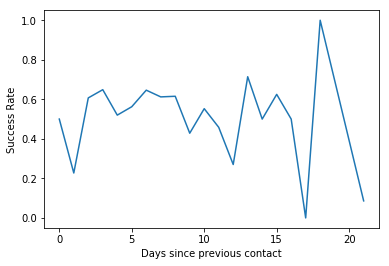

In [0]:
b = df.groupby(['pdays']).agg({'y':['sum','count']})
b['success_rate'] = b['y']['sum']/b['y']['count']

plt.plot(b['success_rate'])
plt.xlabel('Days since previous contact')
plt.ylabel('Success Rate')
plt.show

## Distribution of Variables

done


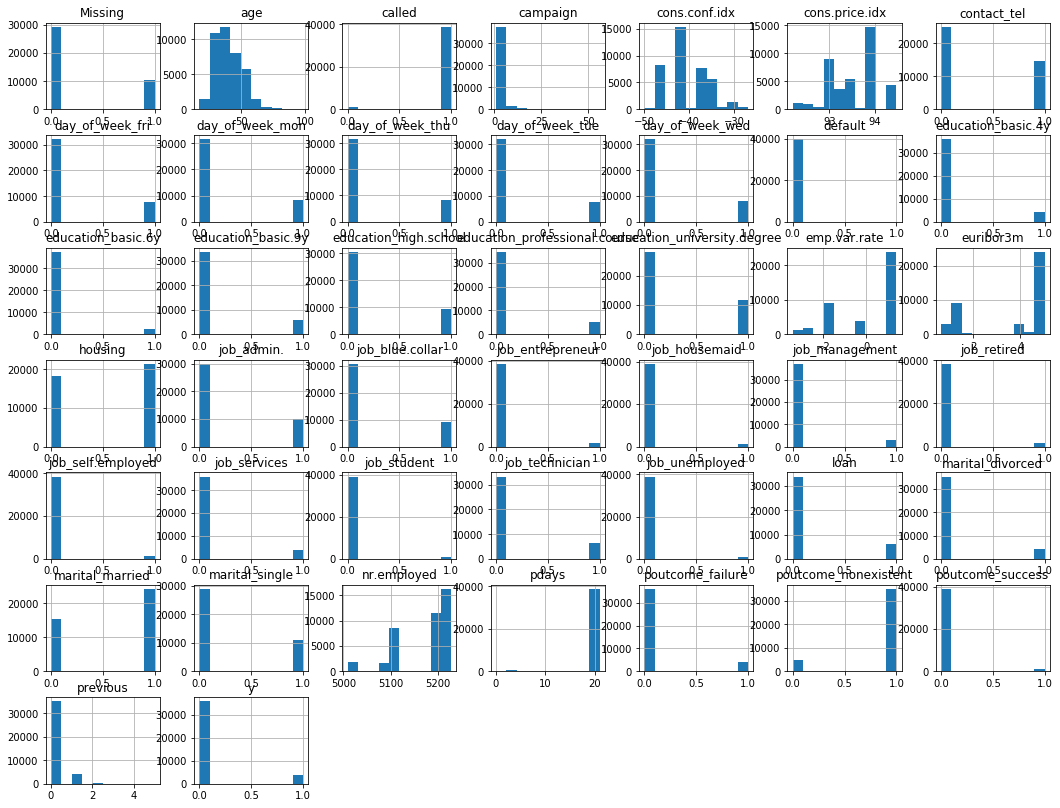

In [0]:
df.hist(figsize  = (18,14))
print('done')

# SMOTE-ing the data

Resample the training data to make up for imbalanced target variable

In [0]:
#Read the date variable again
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df['date'] = df['date'].apply(dateparse)

# SMOTE doesn't like the datetime format, we convert to float
temp_array = np.array([(i - datetime.datetime(2008, 1, 1)) / datetime.timedelta(seconds=1) for i in df['date']])
df['date'] = temp_array.astype('float')

In [0]:
# Split data into X and Y
y, X = df[['y']], df.drop('y', axis = 1)

# Show the counts of each outcome
[print('Class {} has {} instances'.format(label, count))
 for label, count in zip(*np.unique(y, return_counts=True))]

Class 0 has 35844 instances
Class 1 has 3936 instances


[None, None]

In [0]:
# Fit SMOTE
kmeans_smote = KMeansSMOTE(kmeans_args={'n_clusters': 100},
                           smote_args={'k_neighbors': 10})
X_resampled, y_resampled = kmeans_smote.fit_sample(X, y)

[print('Class {} has {} instances after oversampling'.format(label, count))
 for label, count in zip(*np.unique(y_resampled, return_counts=True))]

Class 0 has 35844 instances after oversampling
Class 1 has 35844 instances after oversampling


[None, None]

In [0]:
X_resampled, y_resampled = pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

X_resampled.columns = X.columns
y_resampled.columns = ['y']

X_resampled.head()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,called,date,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
0,56.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,57.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,37.0,0.0,1.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,56.0,0.0,0.0,1.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [0]:
X_resampled.shape

(71688, 45)

In [0]:
df = pd.concat([X_resampled,y_resampled], axis = 1)
df.head()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,called,date,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing,y
0,56.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,57.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2,37.0,0.0,1.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,40.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,56.0,0.0,0.0,1.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


## Save Resampled data

In [0]:
df.to_csv('train_resampled.csv',  index = False)

# Dimension Reduction by Principal Component Analysis

## Training Data and Validation

In [0]:
df = pd.read_csv('train_resampled.csv')
df.drop('education_illiterate', axis = 1, inplace=True)

# Separate predictors and 
X = df.drop('y', axis = 1)
Y = df[['y']]

X.head()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,called,date,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
0,56.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,57.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,37.0,0.0,1.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40.0,0.0,0.0,0.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,56.0,0.0,0.0,1.0,1.0,1.0,21.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0,10454400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [0]:
# Standardise the X variables
X_Std = StandardScaler().fit_transform(X)
X_Std = pd.DataFrame(X_Std, columns = X.columns)
X_Std.head()

,age,default,housing,loan,contact_tel,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,called,date,job_admin.,job_blue.collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self.employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,Missing
0,1.032759,-0.006469,-1.229476,-0.458782,1.778788,-0.57317,0.551636,-0.620925,1.19003,0.751294,0.821099,1.268873,0.954711,0.567109,-1.35215,-0.656422,-0.436298,-0.156501,7.059059,-0.287291,-0.315374,-0.183983,-0.305946,-0.316216,-0.444035,-0.235407,-0.346243,0.831231,-0.660136,3.274535,-0.193509,-0.373708,-0.578569,-0.410102,-0.762101,-0.520517,2.284123,-0.603647,-0.492361,-0.581266,-0.408981,0.76284,-0.548368,-0.561449
1,1.107914,-0.006469,-1.229476,-0.458782,1.778788,-0.57317,0.551636,-0.620925,1.19003,0.751294,0.821099,1.268873,0.954711,0.567109,-1.35215,-0.656422,-0.436298,-0.156501,-0.160180,-0.287291,-0.315374,-0.183983,3.635040,-0.316216,-0.444035,-0.235407,-0.346243,0.831231,-0.660136,-0.341016,-0.193509,-0.373708,1.995233,-0.410102,-0.762101,-0.520517,2.284123,-0.603647,-0.492361,-0.581266,-0.408981,0.76284,-0.548368,1.981406
2,-0.395184,-0.006469,0.946300,-0.458782,1.778788,-0.57317,0.551636,-0.620925,1.19003,0.751294,0.821099,1.268873,0.954711,0.567109,-1.35215,-0.656422,-0.436298,-0.156501,-0.160180,-0.287291,-0.315374,-0.183983,3.635040,-0.316216,-0.444035,-0.235407,-0.346243,0.831231,-0.660136,-0.341016,-0.193509,-0.373708,1.995233,-0.410102,-0.762101,-0.520517,2.284123,-0.603647,-0.492361,-0.581266,-0.408981,0.76284,-0.548368,-0.561449
3,-0.169719,-0.006469,-1.229476,-0.458782,1.778788,-0.57317,0.551636,-0.620925,1.19003,0.751294,0.821099,1.268873,0.954711,0.567109,-1.35215,1.791984,-0.436298,-0.156501,-0.160180,-0.287291,-0.315374,-0.183983,-0.305946,-0.316216,-0.444035,-0.235407,-0.346243,0.831231,-0.660136,-0.341016,5.341894,-0.373708,-0.578569,-0.410102,-0.762101,-0.520517,2.284123,-0.603647,-0.492361,-0.581266,-0.408981,0.76284,-0.548368,-0.561449
4,1.032759,-0.006469,-1.229476,2.572572,1.778788,-0.57317,0.551636,-0.620925,1.19003,0.751294,0.821099,1.268873,0.954711,0.567109,-1.35215,-0.656422,-0.436298,-0.156501,-0.160180,-0.287291,-0.315374,-0.183983,3.635040,-0.316216,-0.444035,-0.235407,-0.346243,0.831231,-0.660136,-0.341016,-0.193509,-0.373708,1.995233,-0.410102,-0.762101,-0.520517,2.284123,-0.603647,-0.492361,-0.581266,-0.408981,0.76284,-0.548368,-0.561449


In [0]:
# Define function to output PCA dataset
def PCA_DF(n_components, DF):
  pca = PCA(n_components)
  PrincComp = pca.fit_transform(DF)
  return pd.DataFrame(data = PrincComp)

In [0]:
# Evaluate MSE of different PCAs to determine the best accuracy/computation tradeoff
LR = LogisticRegression()
Eval = {'PCs':[], 'MSE':[]}
for PCs in range(10,40,3):
  # Create PCA dataframe
  principalDf = PCA_DF(PCs, X_Std)
  
  # Use to train Logistic Regression model
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(principalDf, Y, test_size=0.3)
  LR.fit(X_Train, Y_Train)
  predictions = LR.predict(X_Test)

  #Evaluate the model
  mse = mean_squared_error(predictions, Y_Test)
  Eval['PCs'].append(PCs)
  Eval['MSE'].append(mse)
pd.DataFrame(Eval['MSE'], index = Eval['PCs'])

,0
10,0.076626
13,0.074534
16,0.067327
19,0.063468
22,0.061561
25,0.065235
28,0.063235
31,0.063282
34,0.056493
37,0.056354


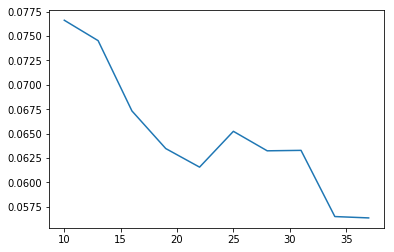

In [0]:
# Best PCA value is between 17 and 24
plt.plot(pd.DataFrame(Eval['MSE'], index = Eval['PCs']))

In [0]:
LR = LogisticRegression()
Eval = {'PCs':[], 'MSE':[]}
for PCs in range(17,24):
  # Create PCA dataframe
  principalDf = PCA_DF(PCs, X_Std)

  # Use to train Logistic Regression model
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(principalDf, Y, test_size=0.3)
  LR.fit(X_Train, Y_Train)
  predictions = LR.predict(X_Test)

  #Evaluate the model
  mse = mean_squared_error(predictions, Y_Test)
  Eval['PCs'].append(PCs)
  Eval['MSE'].append(mse)
pd.DataFrame(Eval['MSE'], index = Eval['PCs'])

,0
17,0.069094
18,0.067978
19,0.065281
20,0.063096
21,0.064863
22,0.061794
23,0.064258


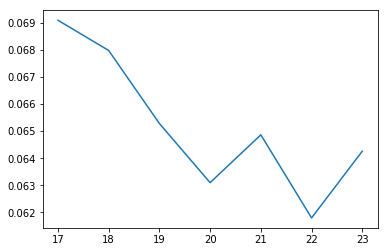

In [0]:
# Best PCA value is between ~21, but it varies based on validation set
plt.plot(pd.DataFrame(Eval['MSE'], index = Eval['PCs']))

## Test Data

In [0]:
# Process Testing data, same as training
df_eval = pd.read_csv("eval_nomissing.csv")

# Convert date to float
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_eval['date'] = df_eval['date'].apply(dateparse)
temp_array = np.array([(i - datetime.datetime(2008, 1, 1)) / datetime.timedelta(seconds=1) for i in df_eval['date']])
df_eval['date'] = temp_array.astype('float')

# Standardise the X variables
X_Std_Test = StandardScaler().fit_transform(df_eval)
X_Std_Test = pd.DataFrame(X_Std_Test, columns = X.columns)

In [0]:
# Confirm the shapes are as they should be
a = [X_Std_Test, df_eval, X_Std, X]
for i in a:
  print(i.shape)

(1408, 44)
(1408, 44)
(71688, 44)
(71688, 44)


In [0]:
# Determine 20 PCA Variables is a good balance between accuracy and computation time
train_PCA = PCA_DF(20, X_Std)
train_PCA['y'] = Y
eval_PCA = PCA_DF(20, X_Std_Test)

train_PCA.to_csv('train_PCA.csv',  index = False)
eval_PCA.to_csv('eval_PCA.csv',  index = False)

print('Training and Testing Data have been cleaned and saved')

Training and Testing Data have been cleaned and saved


# Model Selection

In [0]:
# Load dataset
df = pd.read_csv('train_PCA.csv')

# Separate predictors and 
X = df.drop(['y'], axis = 1)
Y = df[['y']]

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,y
0,3.022759,3.060038,0.236262,0.948416,-1.351847,1.294404,-1.140371,-1.566850,-0.112316,2.314895,-0.000473,2.047378,-2.848666,0.492646,0.557179,3.073254,0.664870,2.437851,-0.664434,-3.065045,-0.376773,0.113489,0
1,3.203837,0.931471,-0.862355,1.286235,-0.702691,1.348960,3.251938,-0.483841,0.897433,0.934681,-0.499172,2.255251,-1.244031,-0.116442,-0.737699,-0.762724,-0.381645,0.405209,-0.056234,1.062990,-0.671469,0.797996,0
2,3.038099,0.225251,-0.867163,0.674115,-0.231554,1.254924,3.386928,-0.723717,0.138527,0.880393,-1.393483,1.969953,-0.352178,-0.233096,-0.007664,-1.144095,-0.736501,1.071254,0.009676,0.262879,-0.646152,0.267119,0
3,3.143911,1.084165,-0.804302,-0.636695,-0.091847,-1.005701,0.373463,-0.775557,0.390765,0.653446,-1.078418,1.378673,0.306624,-2.082969,-3.066517,0.337502,1.007661,-2.215189,0.050364,-0.743423,-2.121281,1.257491,0
4,3.024959,0.821624,-0.515983,0.678410,-0.626748,1.477460,3.771342,-0.536630,-0.178255,1.123600,-1.412282,2.091507,-0.339622,-0.242288,-1.699286,-1.386770,-0.255526,0.460758,0.184403,-0.169370,1.703271,0.300248,0


## Model Evaluation Round 1

In [0]:
# Split Data to Train and Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.25)

# Create a list with all the models we use
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))

# Predictions
names = []
Probs = {}
Preds = {}

# Validation set to evaluate model
for name, model in models:
    #Return probability predictions, not just classification
    model.probability = True

    # Fit the model, make predictions
    model.fit(X_Train, Y_Train)
    probs = model.predict_proba(X_Test)
    predictions = np.where(probs[:,1] > 0.5, 1, 0)
    
    # Save predictions
    Probs[name] = probs[:,1]
    Preds[name] = predictions

    # Evaluate the model
    score = roc_auc_score(Y_Test, predictions)
    mse = mean_squared_error(predictions, Y_Test)

    AUROC.append(score)
    MSE.append(mse)
    names.append(name)

print('done')

done


## Round 2

In [0]:
# Create a list with all the models we use
models = []
models.append(('SVM', SVC()))

# Validation set to evaluate model
for name, model in models:
    #Return probability predictions, not just classification
    model.probability = True

    # Fit the model, make predictions
    model.fit(X_Train, Y_Train)
    probs = model.predict_proba(X_Test)
    predictions = np.where(probs[:,1] > 0.5, 1, 0)
    
    # Save predictions
    Probs[name] = probs[:,1]
    Preds[name] = predictions

    # Evaluate the model
    score = roc_auc_score(Y_Test, predictions)
    mse = mean_squared_error(predictions, Y_Test)

    AUROC.append(score)
    MSE.append(mse)
    names.append(name)

print('done')

done


## Round 3

In [0]:
# Create a list with all the models we use
models = []
models.append(('RFC', RandomForestClassifier()))

# Validation set to evaluate model
for name, model in models:
    #Return probability predictions, not just classification
    model.probability = True

    # Fit the model, make predictions
    model.fit(X_Train, Y_Train)
    probs = model.predict_proba(X_Test)
    predictions = np.where(probs[:,1] > 0.5, 1, 0)
    
    # Save predictions
    Probs[name] = probs[:,1]
    Preds[name] = predictions

    # Evaluate the model
    score = roc_auc_score(Y_Test, predictions)
    mse = mean_squared_error(predictions, Y_Test)

    AUROC.append(score)
    MSE.append(mse)
    names.append(name)

print('done')

done


## Results

<Figure size 432x288 with 0 Axes>

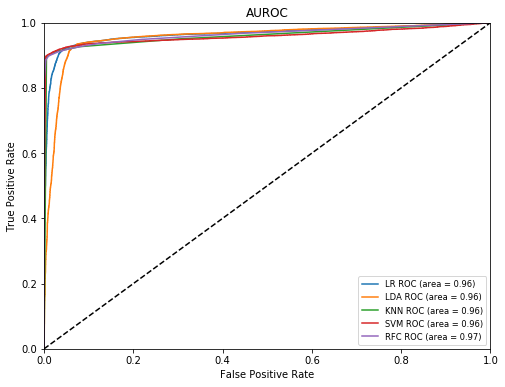

In [0]:
plt.clf()
plt.figure(figsize=(8,6))

# Validation set to evaluate model
for name in names:
    # Plot AUROC curve - data
    fpr, tpr, thresholds = roc_curve(Y_Test, Probs[name])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, roc_auc))

# Plotting details
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('AUROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()


In [0]:
pd.DataFrame({'Model':names,'AUROC':AUROC,'MSE':MSE}).sort_values(by = ['AUROC'], ascending = False)

,Model,AUROC,MSE
3,SVM,0.944742,0.055295
2,KNN,0.941277,0.058755
4,RFC,0.938153,0.061879
0,LR,0.934952,0.065060
1,LDA,0.922032,0.077949


# Predict - Light Gradient Boosting

In [0]:
# Load dataset
train = pd.read_csv('train_PCA.csv')
Eval = pd.read_csv('eval_PCA.csv')

# Get the test index
df = pd.read_csv('Marketing_Eval.csv')
test_ids = df['id']

train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,y
0,3.022751,3.059981,0.236779,0.949543,-1.346811,1.295455,-1.141555,-1.558281,-0.095841,2.328140,-0.001335,2.054437,-2.847196,0.496622,0.564692,3.142617,0.637741,2.297519,-1.212792,-3.046287,0
1,3.203838,0.931446,-0.862091,1.286407,-0.703505,1.347152,3.248068,-0.480266,0.899584,0.938299,-0.511680,2.247743,-1.246531,-0.118969,-0.728632,-0.735529,-0.374011,0.378482,-0.156429,1.057247,0
2,3.038099,0.225085,-0.867327,0.672892,-0.232171,1.253575,3.381533,-0.723309,0.134812,0.880975,-1.408477,1.960042,-0.353348,-0.240290,0.002127,-1.135117,-0.737985,1.042594,-0.229942,0.262769,0
3,3.143878,1.083870,-0.803324,-0.635127,-0.072818,-0.998569,0.371835,-0.761175,0.434603,0.682334,-1.047343,1.407679,0.314506,-2.073937,-3.132965,0.423939,1.119732,-1.971968,0.346875,-0.747192,0
4,3.024958,0.821552,-0.515714,0.678326,-0.626896,1.475844,3.766651,-0.532496,-0.176339,1.131600,-1.428763,2.077047,-0.344370,-0.251954,-1.681279,-1.350276,-0.244737,0.448569,0.097544,-0.190144,0


In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, test_ids, encoding = 'ohe', n_folds = 5):
     
    # Extract the IDs and target
    labels = features['y']
    features = features.drop(columns = ['y'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
    
    # Make the submission dataframe
    submission =pd.DataFrame({'id': test_ids, 'y': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [0]:
submission, fi, metrics = model(train, Eval, test_ids, n_folds = 5)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (71688, 20)
Testing Data Shape:  (1408, 20)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	train's binary_logloss: 0.161308	train's auc: 0.975611	valid's binary_logloss: 0.17723	valid's auc: 0.970572
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.139813	train's auc: 0.984787	valid's binary_logloss: 0.173425	valid's auc: 0.971619
Early stopping, best iteration is:
[203]	train's binary_logloss: 0.139375	train's auc: 0.98498	valid's binary_logloss: 0.173351	valid's auc: 0.971667
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.141346	train's auc: 0.984548	valid's binary_logloss: 0.163608	valid's auc: 0.972596
Early stopping, best iteration is:
[115]	train's binary_logloss: 0.157737	train's auc: 0.976831	valid's binary_logloss: 0.166984	valid's auc: 0.972973
Training until validation scores don't improve for 100 rounds.


In [0]:
sub = submission.sort_values(by = ['y'], ascending = False)
sub = sub.iloc[:500,:]
sub

,id,y
571,40352,0.990113
447,40228,0.988338
577,40358,0.988123
401,40182,0.987525
14,39795,0.986948
26,39807,0.986094
251,40032,0.985893
267,40048,0.985871
657,40438,0.985663
547,40328,0.985381


In [0]:
sub.to_csv('predictions.csv', index = False)

In [0]:
submission.to_csv('predictions_raw.csv')